# Bikeshare rides -- trip classification (Winter 2018)
This notebook explores some ways of classifying stations using various usage parameters. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [2]:
###
subs_df = pd.read_pickle('./data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('./data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('./data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')
###

In [3]:
#Number of weekend days and weekday days for Jan - March 2018
num_WE = 25
num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [6]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

<IPython.core.display.Javascript object>


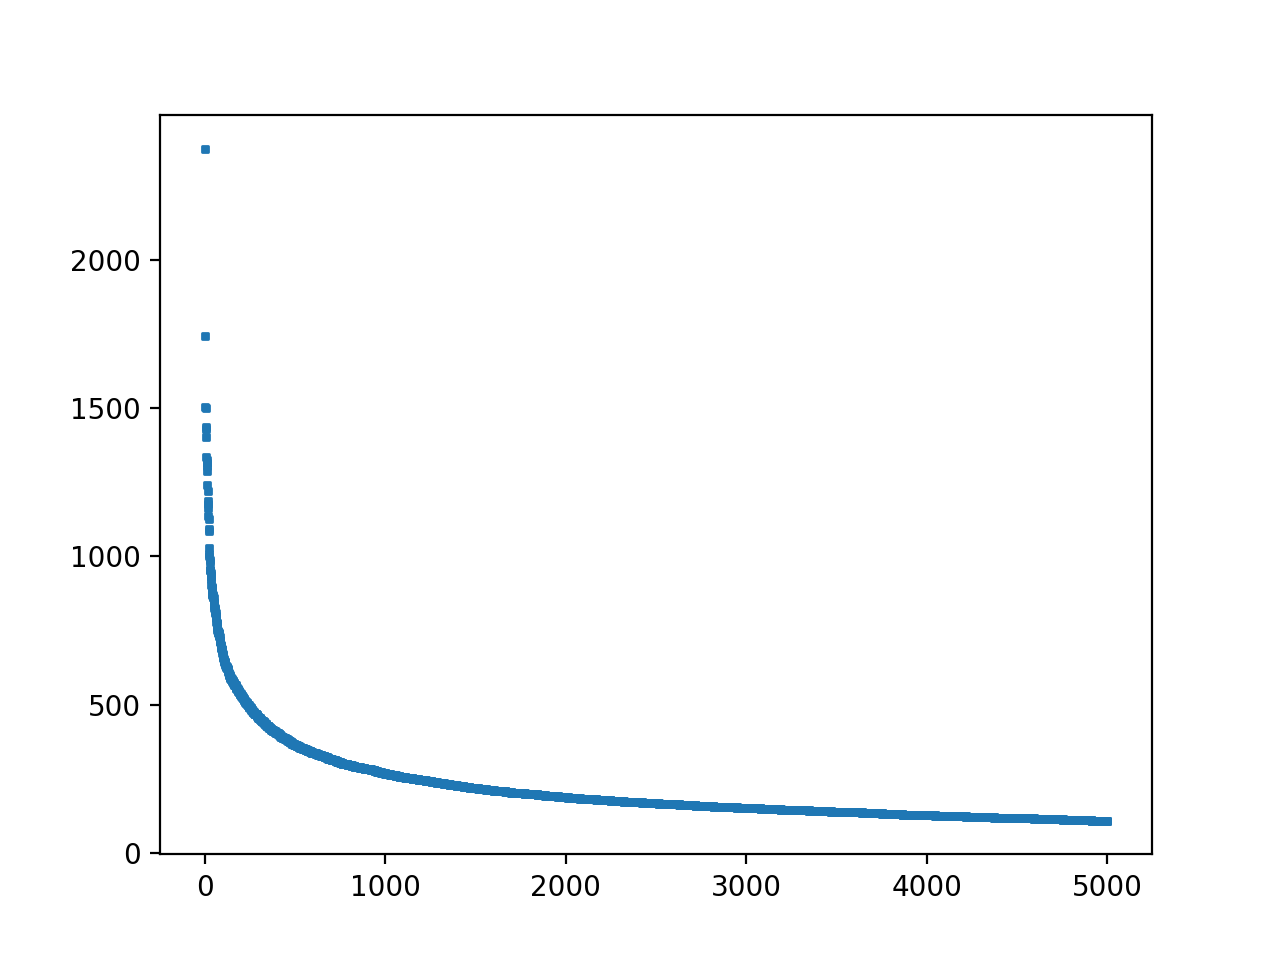

In [108]:
sorted_trips_df = subs_trips_df.groupby('start_end_station').count()['tripduration'].sort_values(ascending=False).reset_index()
sorted_trips_df.rename({'tripduration': 'total_trips'},axis=1,inplace=True)
sorted_trips_df['rank'] = sorted_trips_df.index
#sorted_stations_df['good']

fig = plt.figure()
ax = fig.gca()

ax.scatter(sorted_trips_df['rank'].iloc[0:5000],sorted_trips_df['total_trips'].iloc[0:5000],marker='s',s=5)

<IPython.core.display.Javascript object>


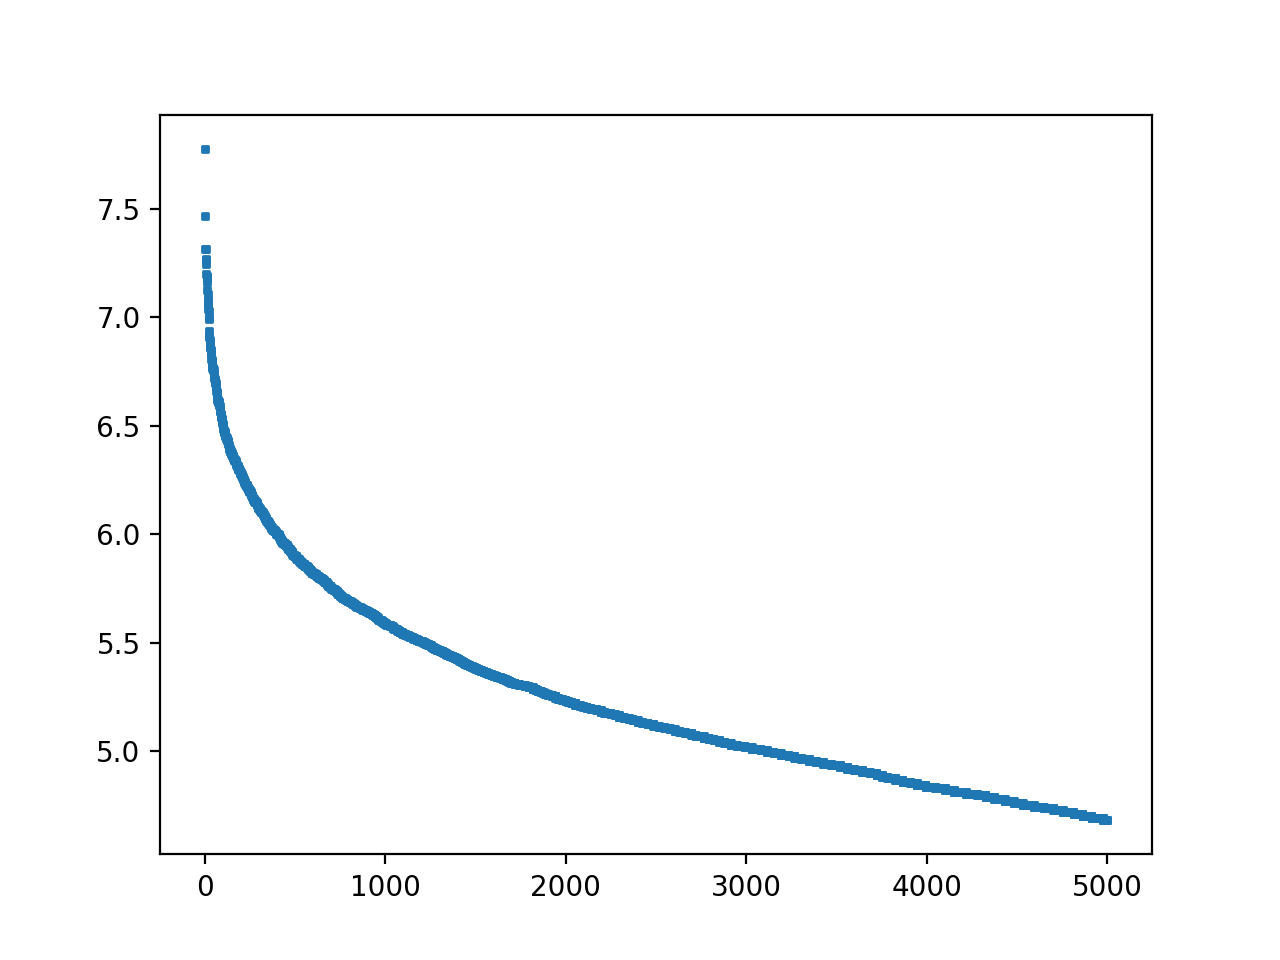

In [109]:
fit=np.polyfit(sorted_trips_df.index[0:5000],np.log(sorted_trips_df['total_trips'][0:5000]), 1)

fit_line = np.array(range(500))*fit[0]+np.full((1,500),fit[1])

fig = plt.figure()
ax = fig.gca()

#ax.scatter(range(800),fit_line)
#ax.plot((1,500),(fit_line[0][1],fit_line[0][499]),color='red')
ax.scatter(sorted_trips_df['rank'].iloc[0:5000],np.log(sorted_trips_df['total_trips'].iloc[0:5000]),marker='s',s=5)


In [115]:
#These are the total trips for each station, sorted from highest to lowest
weekday_sorted_trips_df = weekday_subs_trips_df.groupby('start_end_station').count()['tripduration'].sort_values(ascending=False).reset_index()
weekday_sorted_trips_df.rename({'tripduration': 'total_trips'},axis=1,inplace=True)
weekday_sorted_trips_df['rank'] = weekday_sorted_trips_df.index
weekday_sorted_trips_df.head()

,start_end_station,total_trips,rank
0,"(432, 3263)",2007,0
1,"(460, 3093)",1399,1
2,"(492, 519)",1398,2
3,"(494, 3258)",1310,3
4,"(239, 270)",1284,4


In [116]:
hour_trips_gb = weekday_subs_trips_df.groupby(['pickup_hour','start_end_station'])
count_by_hour_trip_df = hour_trips_gb.count()['tripduration'].rename('num_trips')
num_trips_df = count_by_hour_trip_df.reset_index(level=0).pivot(columns='pickup_hour')
num_trips_df['total_trips'] = num_trips_df.sum(axis=1)

sorted_num_trips_df = num_trips_df.sort_values('total_trips',ascending=False).fillna(0)
sorted_num_trips_df.astype(int)

total = weekday_sorted_trips_df['total_trips'].sum()

sorted_num_trips_df.head()

num_trips                                                   \
pickup_hour               0     1    2    3     4     5      6      7      8   
start_end_station                                                              
(432, 3263)             6.0  10.0  3.0  1.0   2.0   3.0  101.0  160.0  462.0   
(460, 3093)             6.0   1.0  0.0  0.0   0.0   2.0   23.0  176.0  243.0   
(492, 519)             12.0   0.0  0.0  0.0  10.0  25.0  199.0   89.0  106.0   
(494, 3258)            23.0   1.0  3.0  1.0   0.0   1.0    6.0   46.0  112.0   
(239, 270)              7.0   4.0  0.0  0.0   2.0   5.0   99.0   64.0  141.0   

                                                                              \
pickup_hour            9     10    11    12    13    14     15     16     17   
start_end_station                                                              
(432, 3263)        264.0  112.0  75.0  64.0  60.0  54.0   61.0   72.0  108.0   
(460, 3093)        119.0   58.0  37.0  45.0  34.0  29.0   31.0   69.0  165.0   
(492, 519)          39.0    6.0  13.0  14.0  18.0  54.0  166.0  211.0  158.0   
(494, 3258)        200.0   78.0  53.0  52.0  45.0  60.0   63.0   69.0   78.0   
(239, 270)          52.0   24.0  26.0  35.0  35.0  44.0   53.0   58.0  158.0   

                                                        total_trips  
pickup_hour           18     19    20    21    22    23              
start_end_station                                                    
(432, 3263)        141.0   90.0  66.0  39.0  31.0  22.0      2007.0  
(460, 3093)        128.0  107.0  38.0  46.0  29.0  13.0      1399.0  
(492, 519)         133.0   89.0  25.0  15.0  11.0   5.0      1398.0  
(494, 3258)        120.0   95.0  81.0  52.0  40.0  31.0      1310.0  
(239, 270)         222.0  118.0  53.0  37.0  32.0  15.0      1284.0

<IPython.core.display.Javascript object>


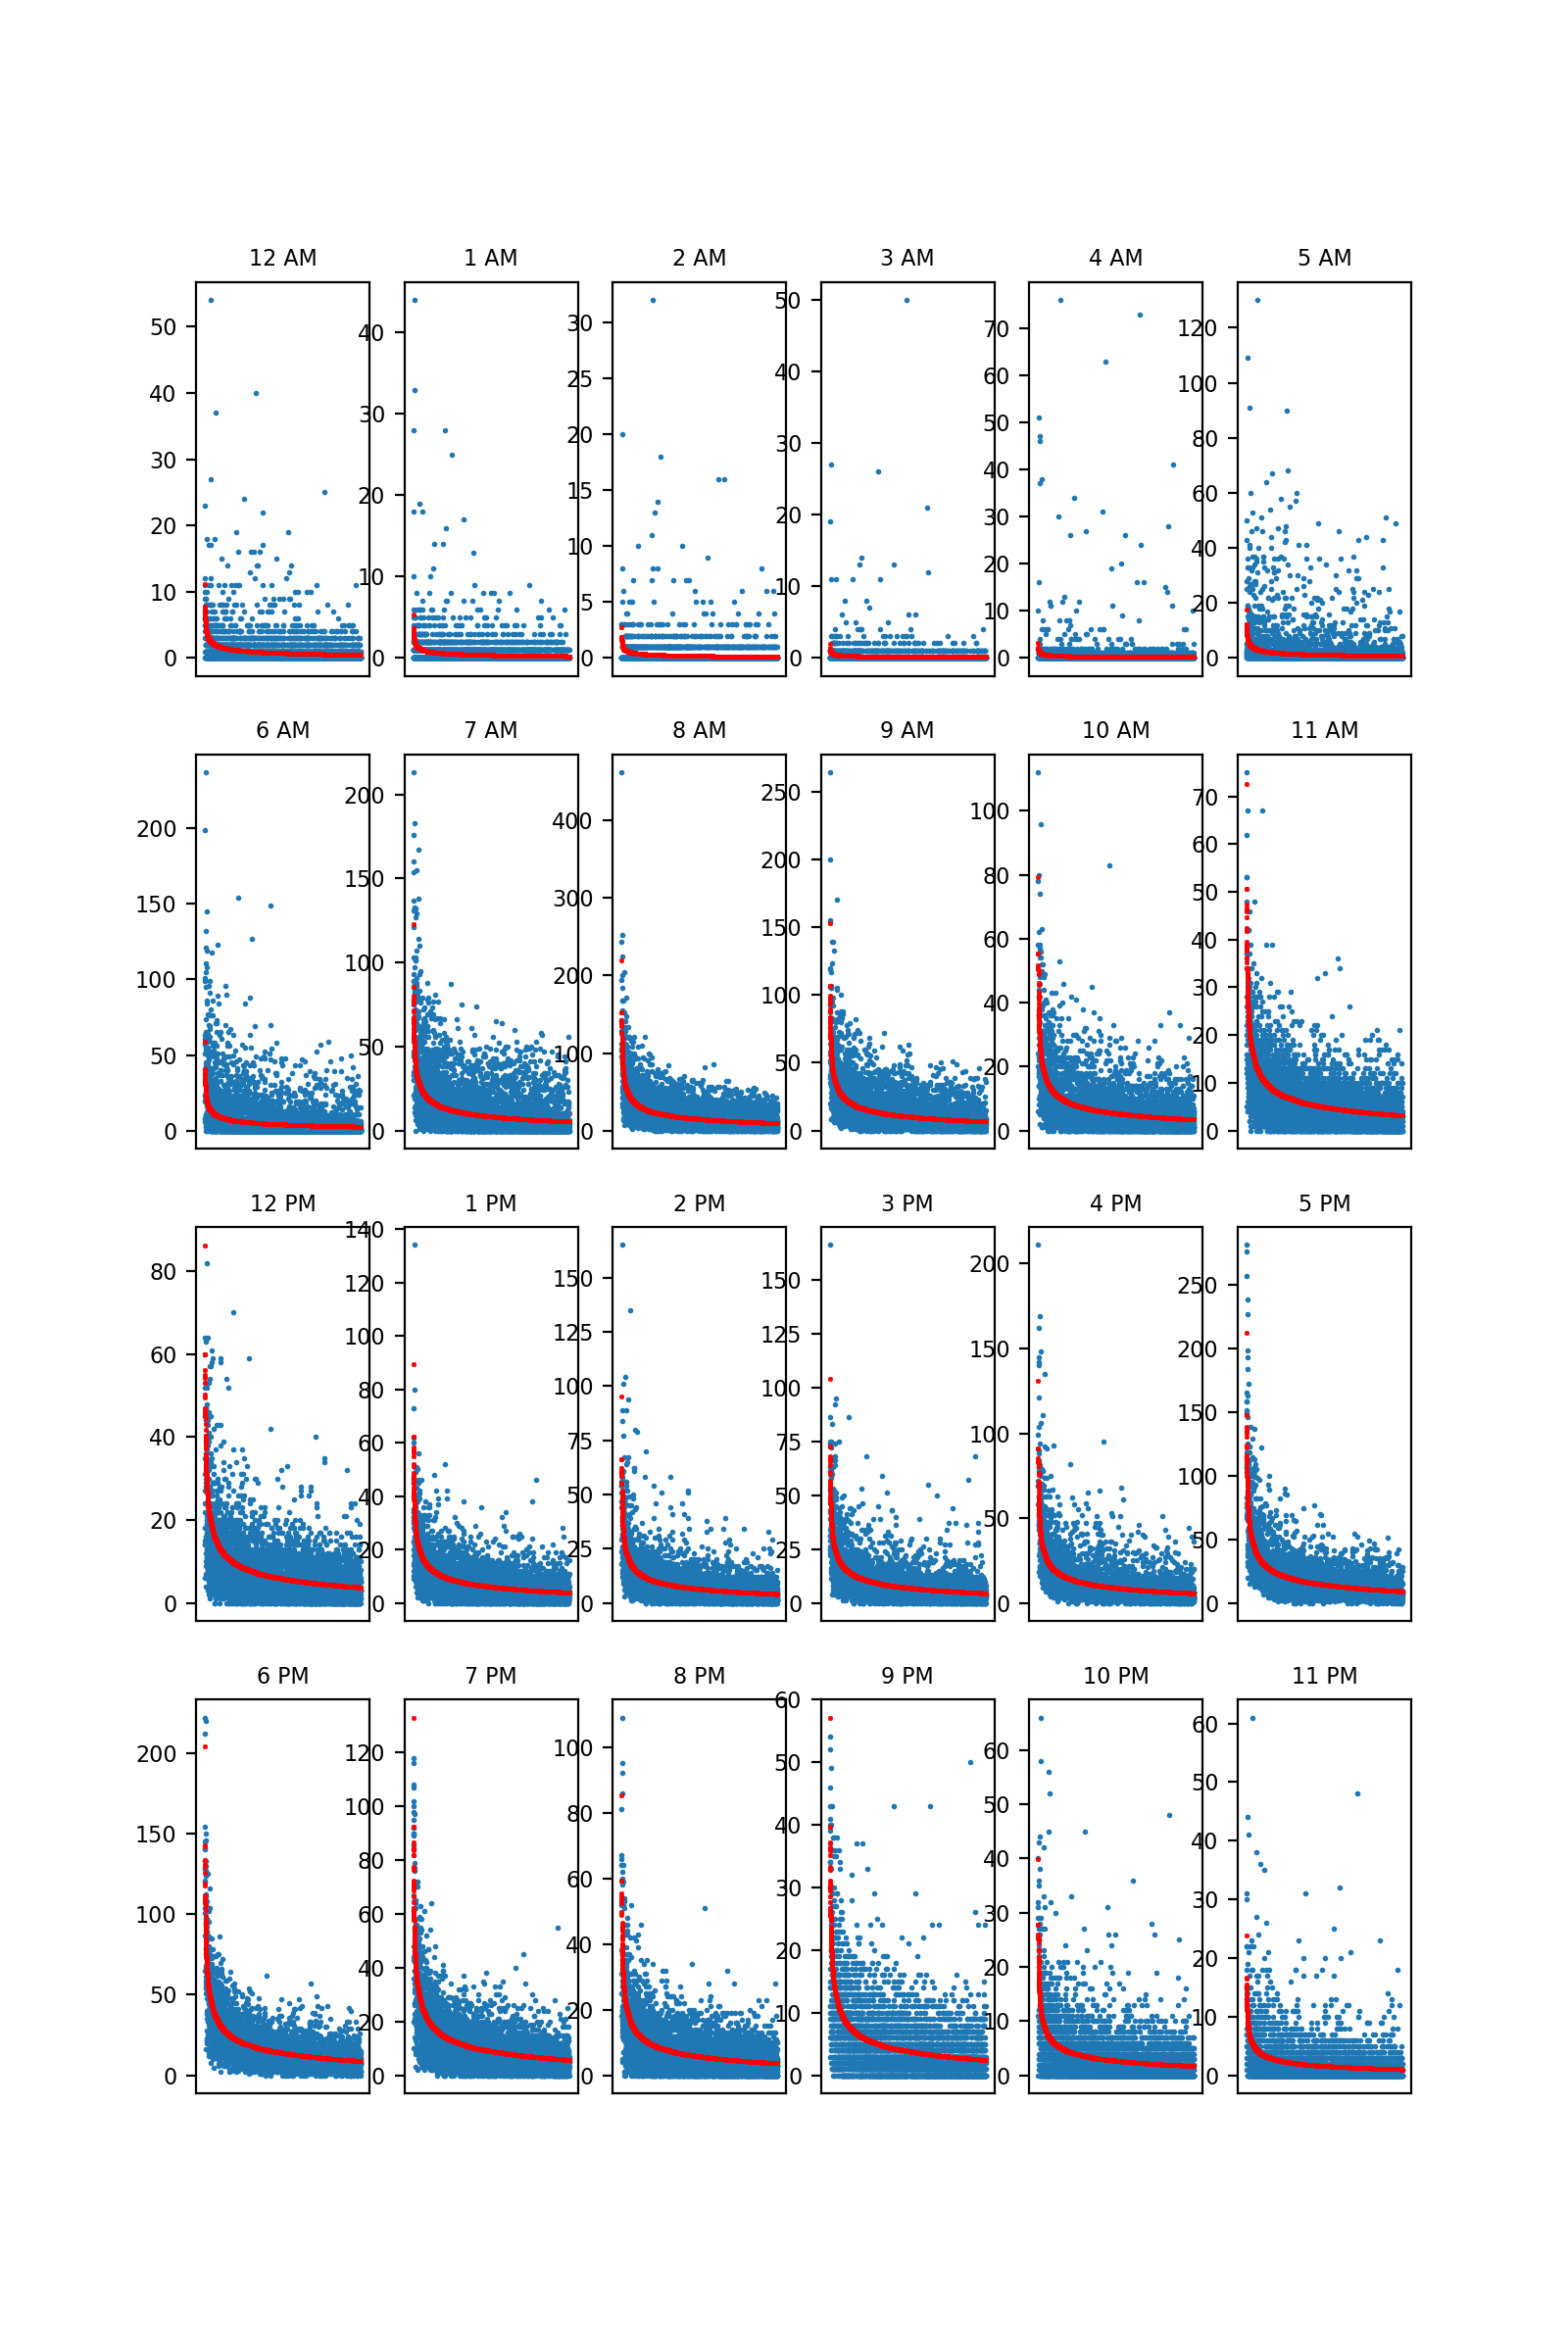

In [117]:
fig, ax = plt.subplots(nrows = 4, ncols = 6, figsize=(8,12))
ax = ax.flatten()

for num in range(24):
    
    if num == 0:
        ax[num].set_title('{} AM'.format(str(12)),fontsize = 8)
    elif num == 12:
        ax[num].set_title('{} PM'.format(str(12)),fontsize = 8)
    elif num < 12:
        ax[num].set_title('{} AM'.format(str(num % 12)),fontsize = 8)
    else:
        ax[num].set_title('{} PM'.format(str(num % 12)),fontsize = 8)

    #ax[num].set_title('hour = {}'.format(num),fontsize = 8)
    #ax[num].scatter(range(len(sorted_num_trips_df.index)),sorted_num_trips_df['num_trips',num],s=1)
    ax[num].scatter(range(5000),sorted_num_trips_df['num_trips',num].iloc[0:5000],s=1)
    
    ax[num].get_xaxis().set_visible(False)
    ax[num].tick_params(labelsize=8)
    weight = sorted_num_trips_df['num_trips',num].sum()
    ax[num].scatter(range(5000),np.divide(np.array(weekday_sorted_trips_df['total_trips'].iloc[0:5000])*weight,total),marker='s',color='red',s=1)
    
    #ax[num].scatter(sorted_trips_df.index,np.divide(np.array(sorted_trips_df['total_trips'])*weight,total),marker='s',color='red',s=1)
    #ax[num].scatter(sorted_stations_df.index,np.divide(np.array(sorted_stations_df['total_trips']),24),marker='s',color='red',s=1)


<IPython.core.display.Javascript object>


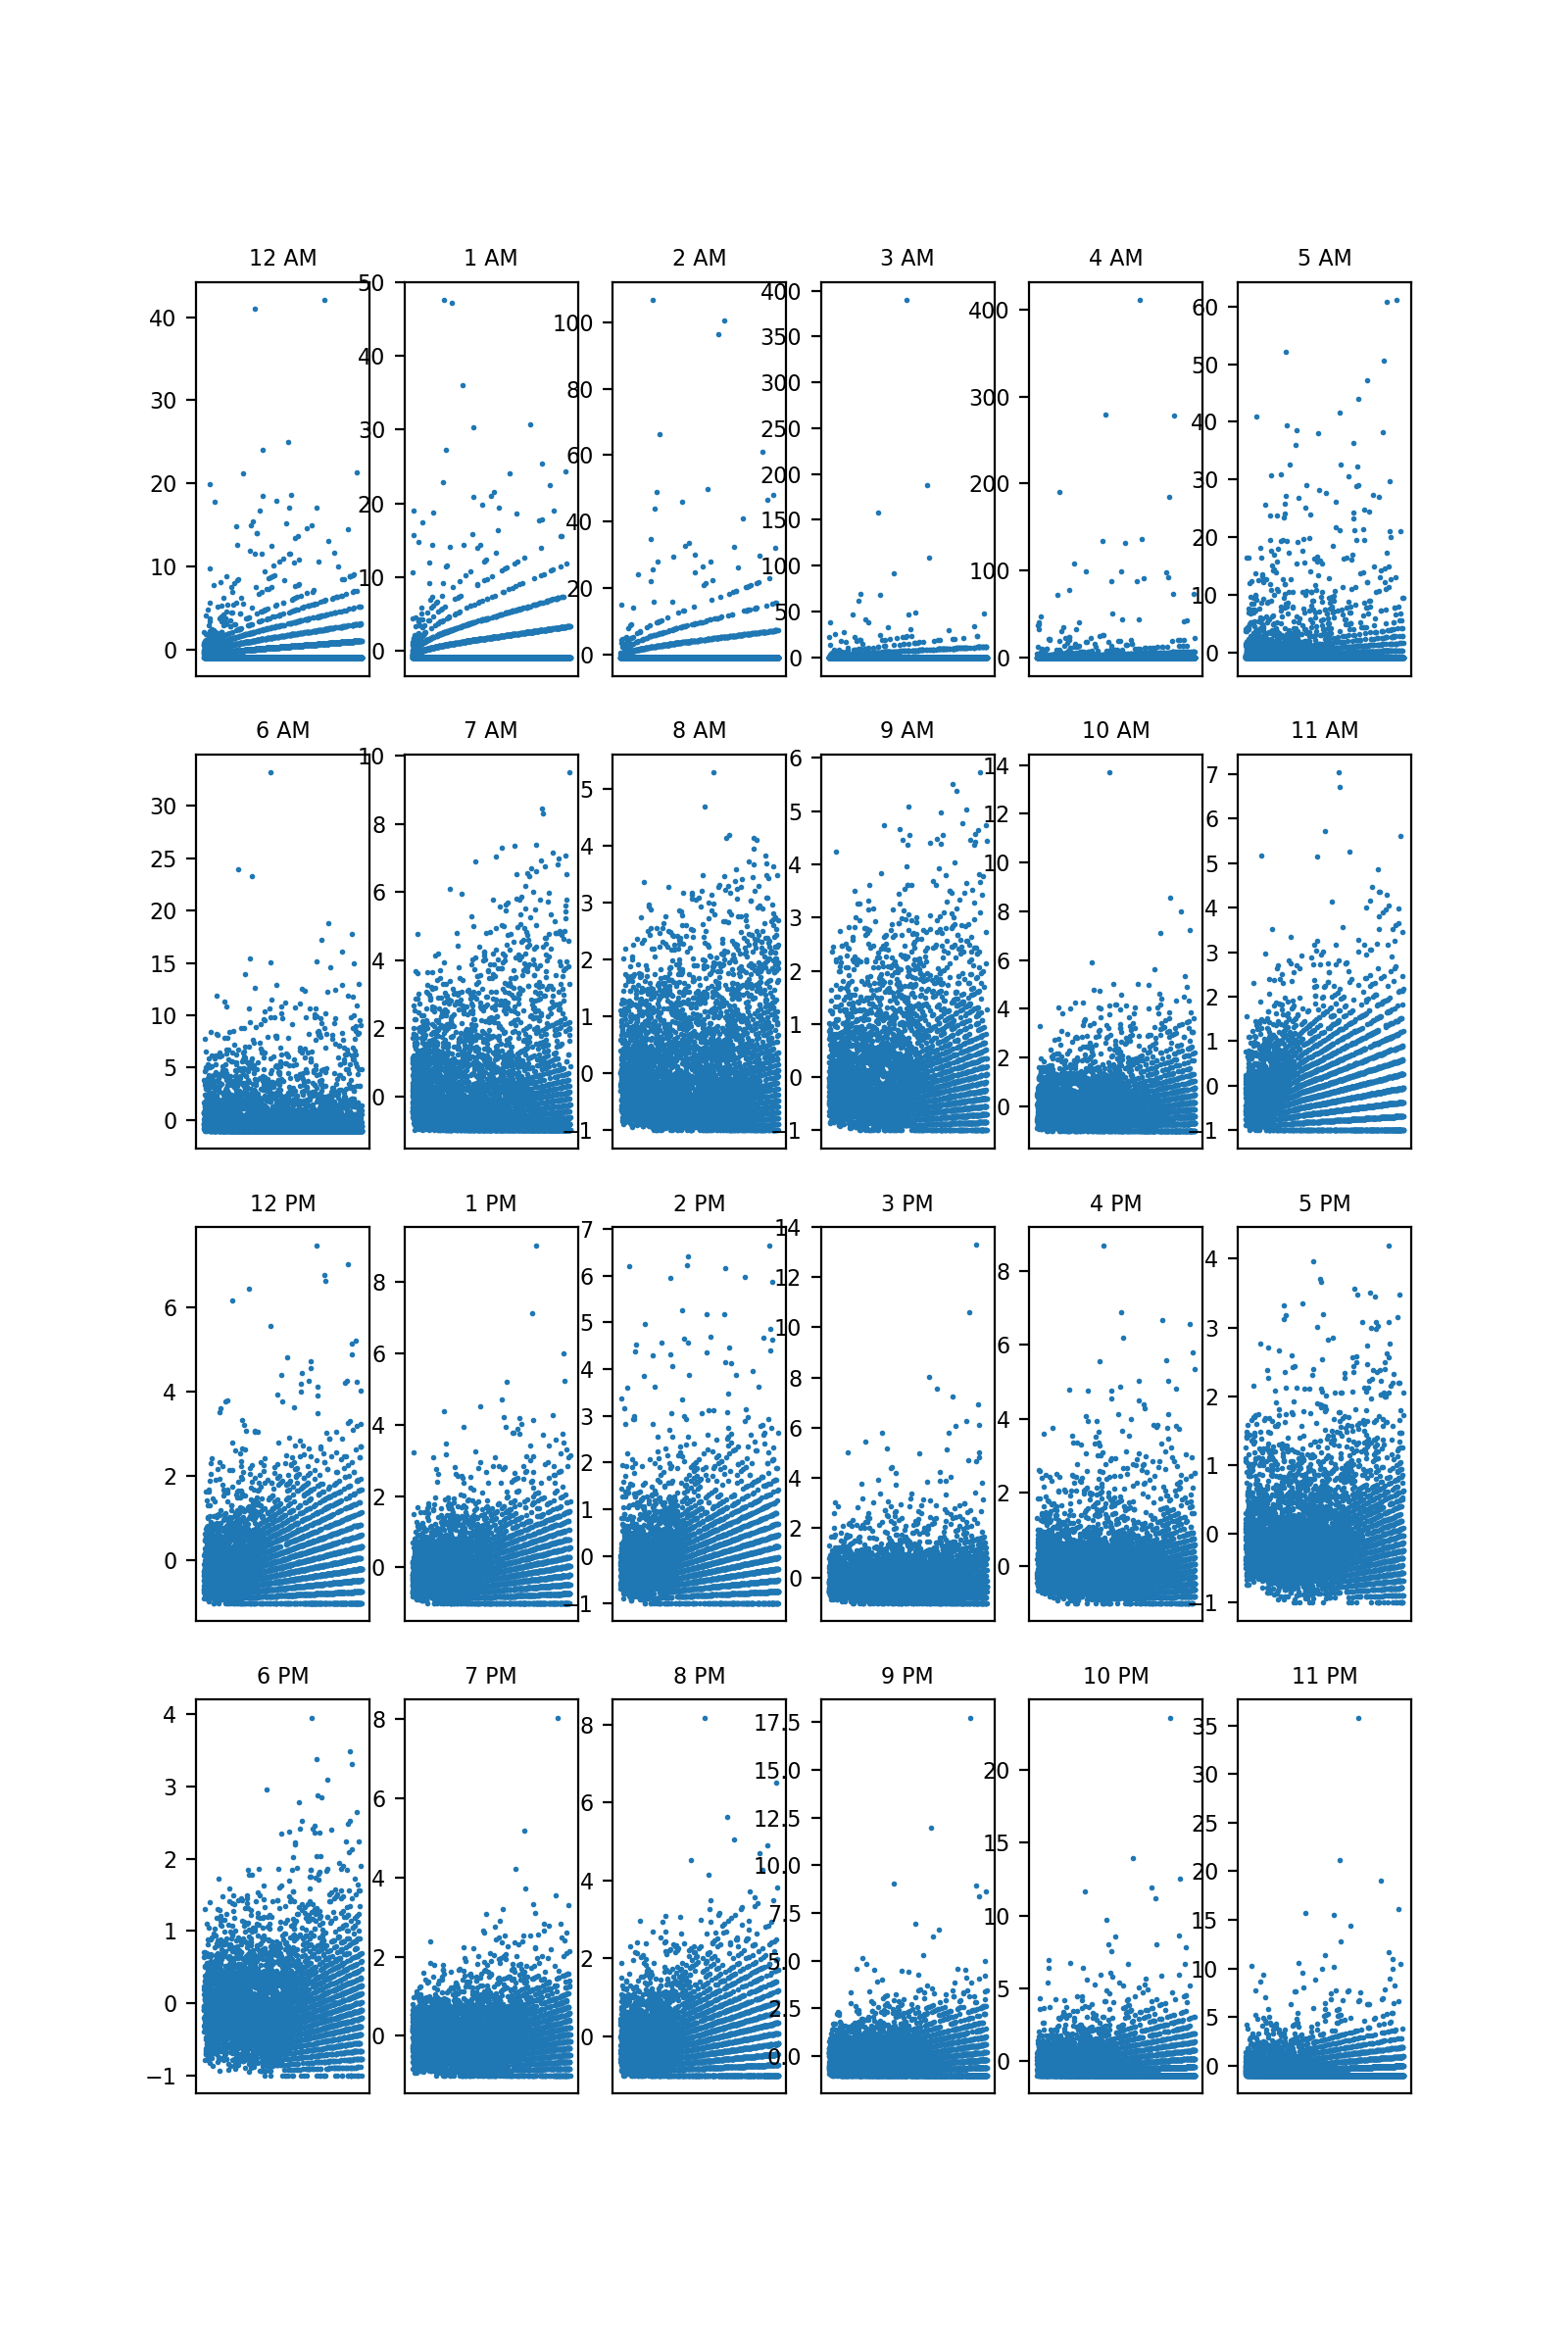

In [119]:

fig, ax = plt.subplots(nrows = 4, ncols = 6, figsize=(8,12))
ax = ax.flatten()

for num in range(24):
    
    if num == 0:
        ax[num].set_title('{} AM'.format(str(12)),fontsize = 8)
    elif num == 12:
        ax[num].set_title('{} PM'.format(str(12)),fontsize = 8)
    elif num < 12:
        ax[num].set_title('{} AM'.format(str(num % 12)),fontsize = 8)
    else:
        ax[num].set_title('{} PM'.format(str(num % 12)),fontsize = 8)
    
    #ax[num].set_title('hour = {}'.format(num),fontsize = 8)
   
    weight = sorted_num_trips_df['num_trips',num].sum()
    normalized = np.divide(np.array(weekday_sorted_trips_df['total_trips'])*weight,total)
    
    diff_score = np.divide(sorted_num_trips_df['num_trips',num].values - normalized,normalized)
    
    #average =  np.divide(np.array(sorted_trips_df['total_trips']),24)
    #diff_score_2 = np.divide(sorted_num_trips_df['num_trips',num].values -average,average)
    
    #diff = sorted_num_trips_df['num_trips',num].values - normalized
    ax[num].scatter(range(5000),diff_score[0:5000],s=1)
    ax[num].get_xaxis().set_visible(False)
    ax[num].tick_params(labelsize=8)
    
    

In [121]:
for num in range(24):
    weight = sorted_num_trips_df['num_trips',num].sum()
    normalized = np.divide(np.array(weekday_sorted_trips_df['total_trips'])*weight,total)
    diff_score = np.divide(sorted_num_trips_df['num_trips',num].values - normalized,normalized)
    #diff_score = np.divide(sorted_num_trips_df['num_trips',num].values - normalized,sorted_num_trips_df['num_trips',num].values)
    
    average =  np.divide(np.array(weekday_sorted_trips_df['total_trips']),24)
    diff_score_2 = np.divide(sorted_num_trips_df['num_trips',num].values -average,average)
    
    sorted_num_trips_df['diff',num] = sorted_num_trips_df['num_trips',num].values - normalized
    sorted_num_trips_df['diff_score',num] = diff_score
    sorted_num_trips_df['diff_score_2',num] = diff_score_2

sorted_num_trips_df['max_diff'] = sorted_num_trips_df['diff'].max(axis=1) 
sorted_num_trips_df['max_diff_time'] = sorted_num_trips_df['diff'].idxmax(axis=1)  

sorted_num_trips_df['max_trips_time'] = sorted_num_trips_df['num_trips'].idxmax(axis=1)

sorted_num_trips_df['max_diff_score'] = sorted_num_trips_df['diff_score'].max(axis=1)  
sorted_num_trips_df['max_diff_score_time'] = sorted_num_trips_df['diff_score'].idxmax(axis=1)  

sorted_num_trips_df['max_diff_score_2'] = sorted_num_trips_df['diff_score_2'].max(axis=1)  
sorted_num_trips_df['max_diff_score_2_time'] = sorted_num_trips_df['diff_score_2'].idxmax(axis=1)  

sorted_num_trips_df['late_night_score'] = sorted_num_trips_df['diff_score',0]
for num in [1,2,3,4,20,21,22,23]:
    sorted_num_trips_df['late_night_score'] += sorted_num_trips_df['diff_score',num]
sorted_num_trips_df['late_night_score'] = sorted_num_trips_df['late_night_score']/len([0,1,2,3,4,20,21,22,23])
    
sorted_num_trips_df['commuter_score'] = sorted_num_trips_df['diff_score',5]
for num in [7,8,9,16,17,18,19]:
    sorted_num_trips_df['commuter_score'] += sorted_num_trips_df['diff_score',num]
sorted_num_trips_df['commuter_score'] = sorted_num_trips_df['commuter_score']/len([5,6,7,8,9,16,17,18,19])

sorted_num_trips_df['midday_score'] = sorted_num_trips_df['diff_score',10]
for num in [11,12,13,14,15]:
    sorted_num_trips_df['midday_score']+=sorted_num_trips_df['diff_score',num]
sorted_num_trips_df['midday_score'] = sorted_num_trips_df['midday_score']/len([10,11,12,13,14,15])


pd.set_option('display.max_columns', None)


sorted_num_trips_df = sorted_num_trips_df.assign(Type =
    np.select(
        condlist=[sorted_num_trips_df['max_diff_score_time'] < 5, sorted_num_trips_df['max_diff_score_time'] <10, sorted_num_trips_df['max_diff_score_time']< 16, sorted_num_trips_df['max_diff_score_time'] <20, sorted_num_trips_df['max_diff_score_time'] < 24], 
        choicelist=['Late Night','Commuter','Midday','Commuter','Late Night'], 
        default='Other'))

#sorted_num_trips_df[['diff_score_2','max_diff_time','max_diff_score_time','max_trips_time','max_diff_score_2_time']]

type_scores=sorted_num_trips_df[['late_night_score', 'commuter_score', 'midday_score']]

sorted_num_trips_df = sorted_num_trips_df.assign(Type2 =
    np.select(
        condlist=[type_scores.idxmax(axis=1) == ('late_night_score',''),type_scores.idxmax(axis=1) == ('commuter_score',''),type_scores.idxmax(axis=1) == ('midday_score','')], 
        choicelist=['Late Night','Commuter','Midday'], 
        default='Other'))

sorted_num_trips_df[['num_trips','total_trips','Type','Type2']]
#type_scores.idxmax(axis=1)

num_trips                                              \
pickup_hour               0     1     2     3     4     5      6      7   
start_end_station                                                         
(432, 3263)             6.0  10.0   3.0   1.0   2.0   3.0  101.0  160.0   
(460, 3093)             6.0   1.0   0.0   0.0   0.0   2.0   23.0  176.0   
(492, 519)             12.0   0.0   0.0   0.0  10.0  25.0  199.0   89.0   
(494, 3258)            23.0   1.0   3.0   1.0   0.0   1.0    6.0   46.0   
(239, 270)              7.0   4.0   0.0   0.0   2.0   5.0   99.0   64.0   
(491, 519)              0.0   1.0   0.0   0.0   0.0  28.0   61.0  213.0   
(498, 519)              4.0  18.0   0.0   0.0   0.0   0.0    8.0   53.0   
(2002, 3093)            5.0   2.0   0.0   0.0   0.0   5.0   63.0   75.0   
(317, 3263)             5.0   0.0   0.0   0.0   2.0   2.0   58.0  154.0   
(477, 519)             10.0   3.0   0.0   0.0   0.0  50.0   24.0   35.0   
(519, 546)              0.0   2.0   0.0   0.0   1.0   1.0   20.0   78.0   
(490, 519)              1.0   0.0   0.0   0.0   0.0   2.0   51.0  131.0   
(3318, 3351)           11.0   5.0   0.0   1.0   1.0   1.0   19.0   44.0   
(3086, 3430)            9.0   6.0   1.0   1.0   0.0   5.0   33.0  137.0   
(363, 3002)             3.0   1.0   8.0   0.0   1.0  43.0   57.0   89.0   
(239, 366)              8.0   1.0   0.0   0.0   1.0   0.0   27.0   77.0   
(3090, 3107)            3.0   0.0   0.0   1.0   0.0   3.0   22.0  121.0   
(435, 509)              0.0   0.0   0.0   0.0   0.0   1.0    5.0   33.0   
(458, 494)              0.0   1.0   0.0   0.0   1.0   2.0   95.0   93.0   
(505, 519)              0.0   1.0   0.0   0.0   0.0   4.0   36.0   66.0   
(458, 3255)             2.0   2.0   0.0   1.0   0.0   3.0  237.0  103.0   
(307, 502)              6.0   1.0   0.0   0.0   1.0   1.0   10.0   33.0   
(499, 3158)             9.0  28.0  20.0  19.0   0.0   4.0   74.0   44.0   
(402, 519)              0.0   0.0   0.0   0.0   0.0   0.0    2.0   30.0   
(453, 459)              1.0   1.0   1.0   1.0   0.0  36.0   45.0   47.0   
(459, 470)              5.0   1.0   0.0   0.0   0.0  12.0   65.0   30.0   
(379, 519)              0.0   0.0   0.0   0.0   0.0   9.0   32.0   21.0   
(459, 3255)             0.0   0.0   0.0   0.0  51.0   9.0  121.0   55.0   
(519, 523)              2.0   0.0   1.0   0.0   0.0   0.0    4.0   11.0   
(435, 459)              3.0   0.0   0.0   0.0   0.0   4.0   10.0   78.0   
...                     ...   ...   ...   ...   ...   ...    ...    ...   
(3135, 3545)            0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(441, 481)              0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3614)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3605)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(248, 461)              0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3602)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3441)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3454)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3467)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3474)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3486)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3501)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3506)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3508)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3509)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3518)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(157, 415)              0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3520)             0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(157, 419)              0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
(440, 3534)             0.0   0.0   0.0   0